In [1]:
import sys

sys.path.append("../")

# Clusterizzazione e classificazione di spettri Raman

F. Paissan, Università degli studi di Trento

Il problema da risolvere è la clusterizzazione di spettri Raman acquisiti da due griglie 11x11 (S1 e S2). Ogni spettrogramma acquisito rappresenta la composizione di minerali all'interno dei campioni (NB: più elementi possono appartenere allo stesso campione, sovrapposizione di spettri).

Ho provato più approcci, dal normale k-means sull'altezza del picco più alto fino al k-medoids con diverse metriche performato sull'interpolazione degli spettrogrammi (senza background).

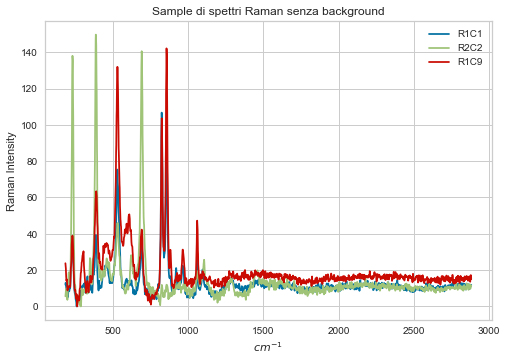

In [12]:
from src.data.utils import read_data
import matplotlib.pyplot as plt

data_S1 = read_data("../data/raw/unlabeled/S1_bkg_mapA_11x11.txt")

plt.xlabel("$cm^{-1}$")
plt.ylabel("Raman Intensity")
plt.title("Sample di spettri Raman senza background")
plt.plot(data_S1.wl, data_S1.r1c1, label="R1C1")
plt.plot(data_S1.wl, data_S1.r2c2, label="R2C2")
plt.plot(data_S1.wl, data_S1.r1c9, label="R1C9")
plt.legend()

## Clusterizzazione

Per questo ho usato k-means e k-medoids. Il funzionamento dei due è praticamente equivalente: l'idea è di trovare i centroidi tali che la funzione di costo $J$ è minimizzata (fissato un numero specifico di parametri).

Per k-means la funzione di costo è espressa come

$$
J = \sum_k^K \sum_n^N r_{nk} \Vert x_n - \mu_k \Vert^2_2
$$

per k-medoids, la funzione di costo è molto simile, con la differenza principale che $\Vert \dot{} \Vert$ rappresenta un'altra metrica come ad esempio cosine distance, correlazione e altre p-norm.

### K-means con posizione dei 5 picchi piu alti

In [5]:
# Generate data
from src.data.make_dataset import make_unlabeled, make_labeled
from src.features.peak_features import gen_n_peak

make_unlabeled("../data/raw/unlabeled", "../data/interim/unlabeled", norm_type = "integral")
features_callback = gen_n_peak(5, "amp")
features_callback("../data/interim/unlabeled", "../data/processed/unlabeled")

In [6]:
# Load and train k-means
from sklearn.cluster import KMeans
import pickle
import glob

file = glob.glob('{0}/*.pkl'.format("../data/processed/unlabeled"))
data_x = pickle.load(open(file[0], "rb"))

model_inertia = []
for n_c in range(1, 60):
    model = KMeans(n_clusters=n_c).fit(data_x.reshape(242, -1))
    model_inertia.append(model.inertia_)
    if n_c == 25:
        centroids = model.cluster_centers_.reshape(25, 2, 5)

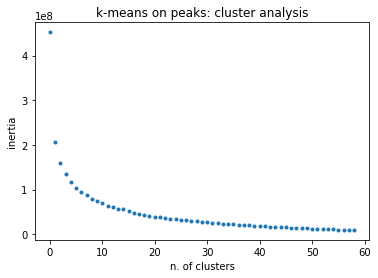

In [7]:
plt.xlabel("n. of clusters")
plt.ylabel("inertia")
plt.title("k-means on peaks: cluster analysis")
plt.plot(model_inertia, '.')

La regola del gomito suggerisce tra i 15 e 25 cluster, ma avremmo comunque un modello con un'inerzia intorno a 32e6. Analizzando le feature di ingresso (oltre che la posizione dei centroidi sugli assi), notiamo che i cluster non sono significativi dal punto di vista dell'analisi spaziale della distribuzione dei picchi.

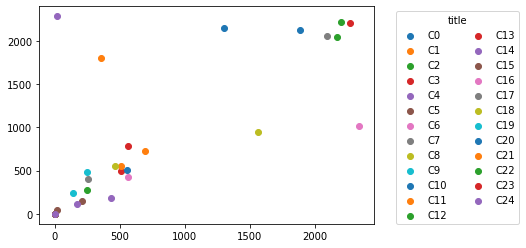

In [8]:
for i, cen in enumerate(centroids):
    plt.scatter(cen[:, 0], cen[:, 1], label = f"C{i}")

plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 2)

Come si nota dall'immagine estratta dal notebook [fp-feature-analysis](fp-feature-analysis.ipynb)

![Peak analysis](../reports/figures/peak_analysis.png)

Per alcuni spettrogrammi i picchi estratti non sono significativi, infatti bisognerebbe mettere una soglia in altezza o distanza, ma essendo il task non supervisionato rischiamo di perdere informazioni significative.

## Clusterizzazione con feature artificiali

Le feature sono state scelte dall'ambito del processing audio e sono:
- varianza del segnale;
- media;
- skewness;
- kurtosis;
- entropia;
- numero di zero-crossings;
- altezza massima del segnale;
- argmax del segnale.

In [3]:
# Generate data
from src.data.make_dataset import make_unlabeled, make_labeled
from src.features.engineered_features import extract_features

make_unlabeled("../data/raw/unlabeled", "../data/interim/unlabeled", norm_type = "default")
extract_features("../data/interim/unlabeled", "../data/processed/unlabeled")

In [5]:
# Load data and train model
from sklearn.cluster import KMeans
import pickle
import glob

file = glob.glob('{0}/*.pkl'.format("../data/processed/unlabeled"))
data_x = pickle.load(open(file[0], "rb"))
model_inertia = []
for n_c in range(1, 60):
    model = KMeans(n_clusters=n_c).fit(data_x.reshape(242, -1))
    model_inertia.append(model.inertia_)

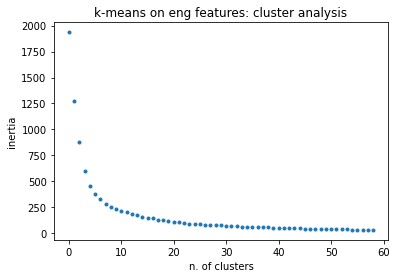

In [8]:
plt.xlabel("n. of clusters")
plt.ylabel("inertia")
plt.title("k-means on eng features: cluster analysis")
plt.plot(model_inertia, '.')

I risultati sono okay... ma vediamo che succede con un'altra metrica.

In [9]:
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cosine
import numpy as np

metric = [
    lambda x,y : np.linalg.norm(x-y), 
    lambda x,y : np.linalg.norm(x-y, ord=1), 
    lambda x,y : cosine(x, y)
]
model_inertia = []
for m in metric:
    temp = []
    for n_c in range(1, 60):
        model = KMedoids(n_clusters=n_c, metric = m).fit(data_x.reshape(242, -1))
        temp.append(model.inertia_)
    model_inertia.append(temp)

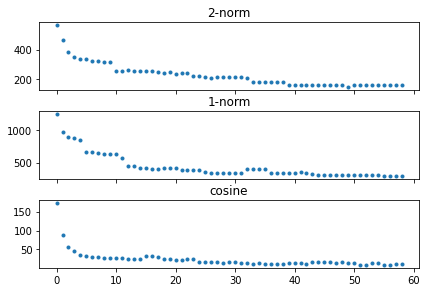

In [10]:
fig, axes = plt.subplots(3, 1, sharex = True)
plt.tight_layout()

l = ["2-norm", "1-norm", "cosine"]
for i in range(3):
    axes[i].set_title(l[i])
    axes[i].plot(model_inertia[i], '.')

L'inerzia è ancora un po' alta, ma meglio di prima. Ora vediamo cosa succede con l'ultimo approccio...

### Interpolazione degli spettrogrammi nel range $[0, 2400]$

In [2]:
# Generate data
from src.data.make_dataset import make_unlabeled, make_labeled
from src.features.n_degree_interp import clean_spec

import pickle
import glob


make_unlabeled("../data/raw/unlabeled", "../data/interim/unlabeled", norm_type = "integral")
clean_spec("../data/interim/unlabeled", "../data/processed/unlabeled")

file = glob.glob('{0}/*.pkl'.format("../data/processed/unlabeled"))
data_x = pickle.load(open(file[0], "rb"))

In [ ]:
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cosine
import numpy as np

# Load data and train model
from sklearn.cluster import KMeans

metric = [
    lambda x,y : np.linalg.norm(x-y), 
    lambda x,y : np.linalg.norm(x-y, ord=1), 
    lambda x,y : cosine(x, y)
]
model_inertia = []
for m in metric:
    temp = []
    for n_c in range(1, 60):
        model = KMedoids(n_clusters=n_c, metric = m).fit(data_x.reshape(242, -1))
        temp.append(model.inertia_)
    model_inertia.append(temp)

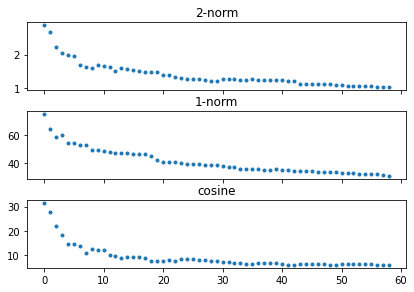

In [31]:
fig, axes = plt.subplots(3, 1, sharex = True)
plt.tight_layout()

l = ["2-norm", "1-norm", "cosine"]
for i in range(3):
    axes[i].set_title(l[i])
    axes[i].plot(model_inertia[i], '.')

Questo sembra decisamente il risultato più convincente (per valori di inerzia). In particulare, è interessante notare come l'inerzia varia in funzione della metrica usata.

Indipendentemente dalla metrica però, il numero di cluster con la regola del gomito si aggira intorno a 13.

Visualizziamo quindi i sample per ogni cluster in modo da fare un analisi visiva del risultato.

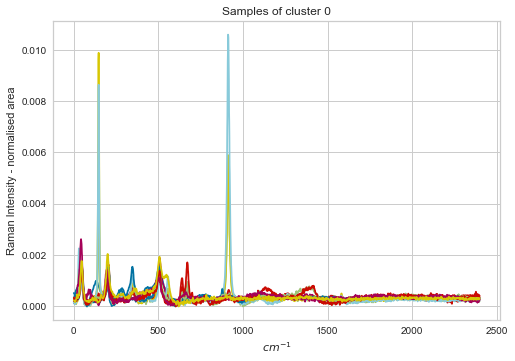

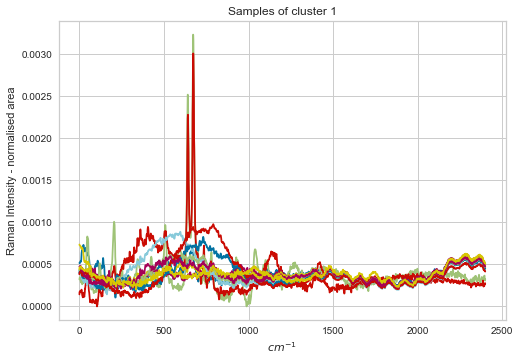

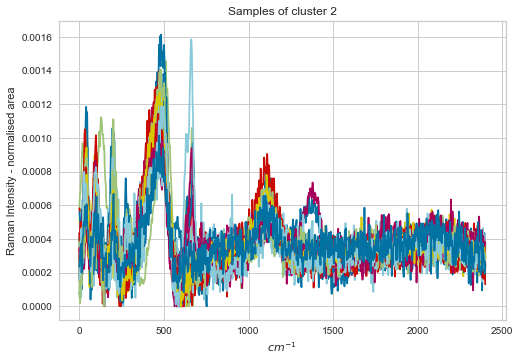

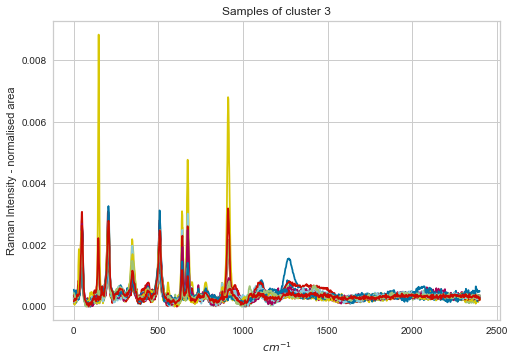

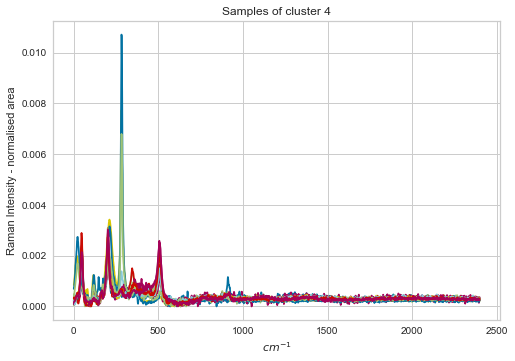

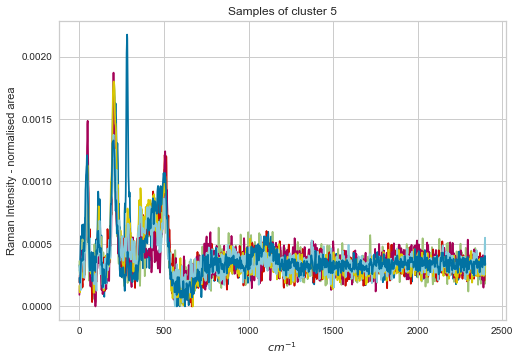

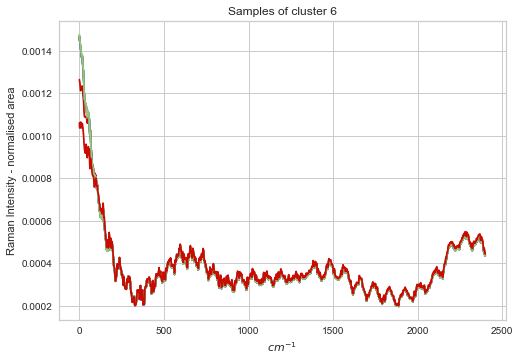

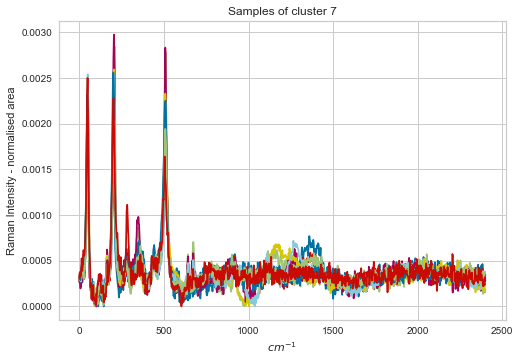

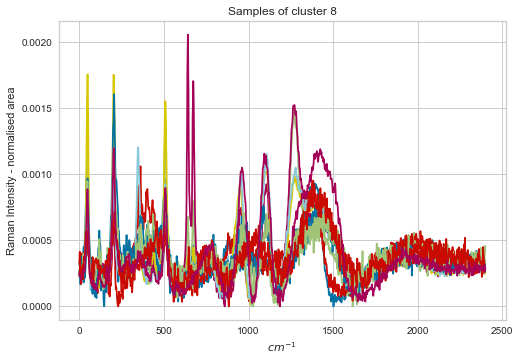

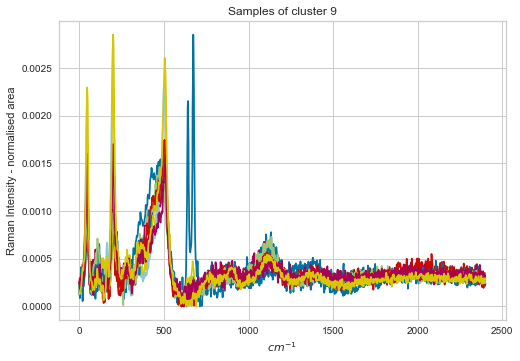

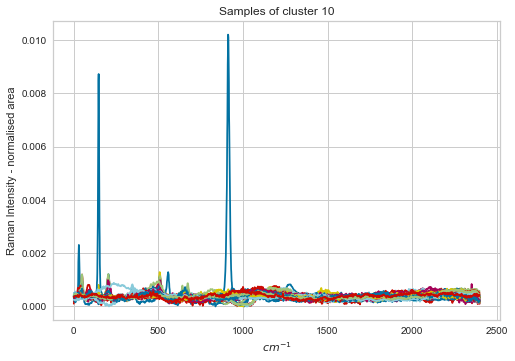

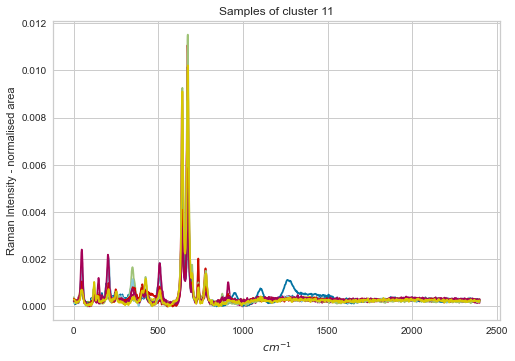

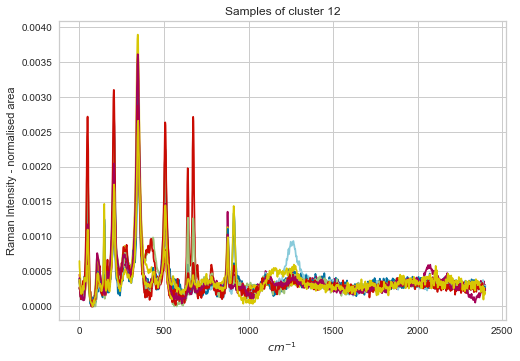

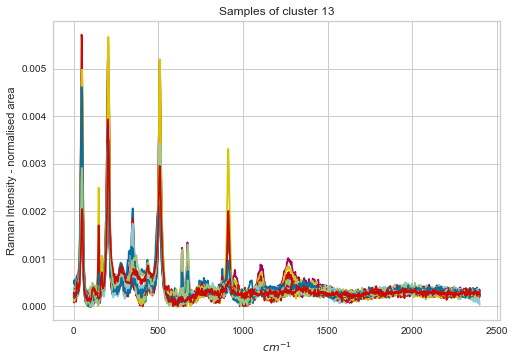

In [27]:
model = KMedoids(n_clusters=14, metric = lambda x, y: np.linalg.norm(x-y)).fit(data_x.reshape(242, -1))
y_pred = model.predict(data_x)

for i, label in enumerate(np.unique(model.labels_)):
    spects = data_x[np.where(model.labels_ == label)[0]]
#     fig, ax = plt.subplots(1, 2)
    for i, s in enumerate(spects):
#         if i == 0 or i == 1:
#             ax[i].plot(s)
            
#             if i == 1:
#                 plt.show()
#                 plt.close('all')
                
                
#             continue
            
        plt.plot(s)
        plt.xlabel("$cm^{-1}$")
        plt.ylabel("Raman Intensity - normalised area")
        plt.title(f"Samples of cluster {label}")
    
    plt.show()
    plt.close('all')

i risultati sono visivamente simili. Per ora ci accontentiamo di questo, fino a che non avremo altre informazioni.

## Classificazione di materiali in spettri Raman

Viene fatta usando la combinazione convessa di spettri di minerali conosciuti. L'abbondanza di ogni materiale corrisponde quindi al coefficiente per ogni spettrogramma.

$$
\textbf{y} = \textbf{X}\textbf{w}, \text{ where } \textbf{X} \in \Bbb R^{2400x61}, \textbf{w} \in \Bbb R^{61} \text{ and } \textbf{y} \in \Bbb R^{2400}
$$

In [30]:
# Define utilities methods
from scipy.interpolate import interp1d

import numpy as np
import glob


def load_interim_samples(path):
    file_list = glob.glob(path + "/*")
    file_list.sort()
    data_unlabeled = []
    for f in file_list:
        interim_data = np.loadtxt(f, delimiter=',', skiprows=1)
        data_unlabeled.append(interim_data)

    return data_unlabeled


def interpolate_signals(data):
    """
    Interpolates signals to enable comparison
    """
    interp_rage = np.arange(0, 2400)
    samples = np.ndarray(shape=(2400, len(data)))
    for i, spec in enumerate(data):
        fit = interp1d(spec[:, 0], spec[:, 1], fill_value="extrapolate")
        samples[:, i] = fit(interp_rage)

    return samples

In [31]:
# Classifier
from sklearn.linear_model import LinearRegression
import pandas as pd

glob_label = glob.glob("../data/interim/labeled/*")
glob_label.sort()
materials_label = [k.split('/')[-1].split('.')[0] for k in glob_label]

data_unlabeled = load_interim_samples("../data/interim/unlabeled")
data_labeled = load_interim_samples("../data/interim/labeled")

samples_labeled = interpolate_signals(data_labeled)
samples_unlabeled = interpolate_signals(data_unlabeled)

def infer_materials(data):
    model = LinearRegression(positive=True).fit(samples_labeled, data)

    quant = pd.DataFrame({
        "label": materials_label,
        "value": model.coef_
    })

    return quant

def extract_material_perc(range_start, range_stop):
    values = np.zeros(shape = (61,))
    for i in range(range_start, range_stop):
        y_pred = infer_materials(samples_unlabeled[:, i])
        values += y_pred.value

    S1_quant_df = pd.DataFrame({"labels": materials_label, "value": values / sum(values)})
    return S1_quant_df

In [32]:
S1 = extract_material_perc(0, 121)
S2 = extract_material_perc(121, 242)

In [35]:
S1.sort_values("value", ascending=False).head(), S2.sort_values("value", ascending=False).head()

(       labels     value
 35  Lizardite  0.228377
 32   Jarosite  0.130944
 60    Zoisite  0.085805
 26   Goethite  0.063572
 3     Anatase  0.060068,
           labels     value
 35     Lizardite  0.241912
 7   Arsenopyrite  0.098528
 4      Andradite  0.069954
 3        Anatase  0.053678
 44    Nontronite  0.041315)

Questi risultati mostrano i cinque materiali più presenti per i campioni S1 e S2 rispettivamente.

## Unendo tutte le informazioni...

Ora conosciamo le abbondanze di materiali per ogni spettrogramma "sconosciuto", quindi possiamo confrontare i sample dello stesso cluster con il proprio centroide e vedere se c'è una compatibilità dal punto di vista dei materiali.

In [33]:
minerali_cluster = [infer_materials(c) for c in model.cluster_centers_]

def compare_materials(spec, min_c):
    """ 
    Computes quantities of minerals per sample in cluster.
    """
    distances = []
    for i, label in enumerate(np.unique(model.labels_)):
        spects = spec[np.where(model.labels_ == label)[0]]
        d_sum = np.zeros(shape=(61, len(np.where(model.labels_ == label)[0])))
        for i, s in enumerate(spects):
            sample_materials = infer_materials(s).sort_values("label", ascending=False).value
            corresponding_cluster = min_c[label - 1].sort_values("label", ascending=False).value
            
            d_sum[:, i] = (sample_materials - corresponding_cluster)
        
        distances.append(np.mean(d_sum, axis = 1))
    
    return distances
        
residuals_materiali = compare_materials(data_x, minerali_cluster)

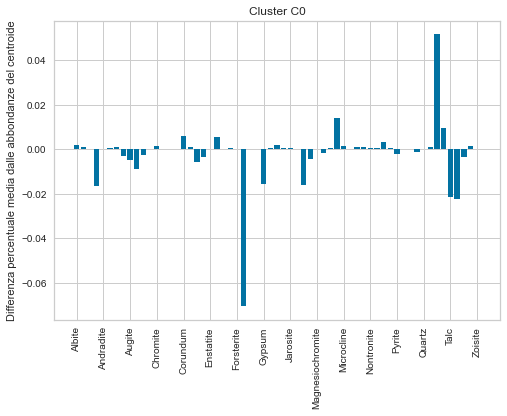

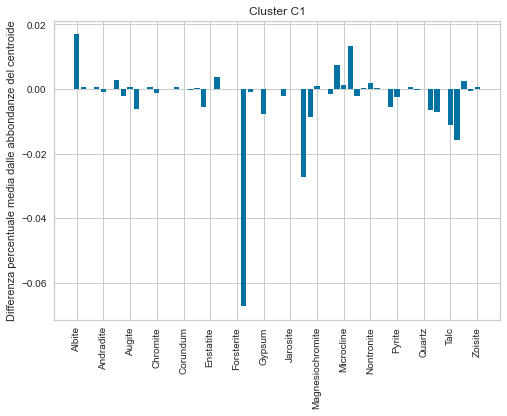

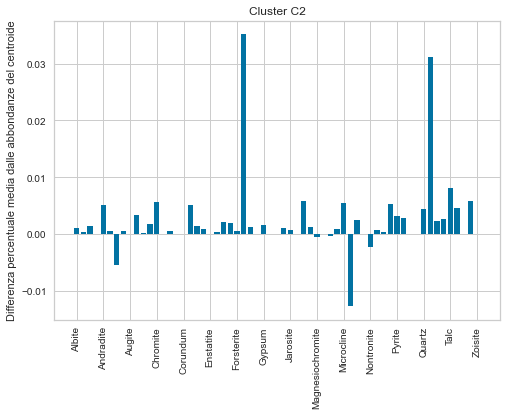

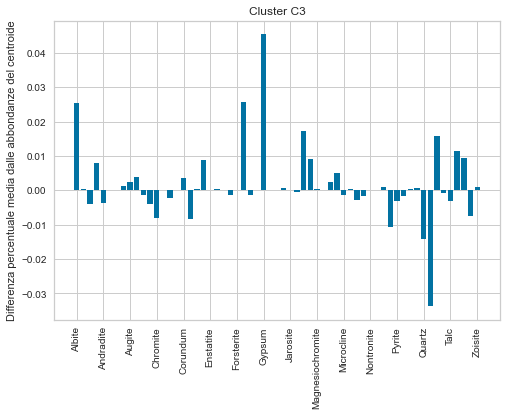

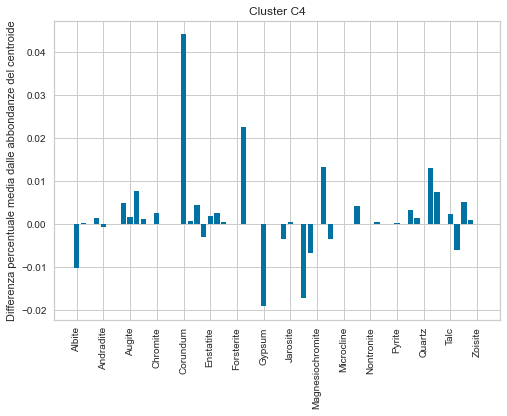

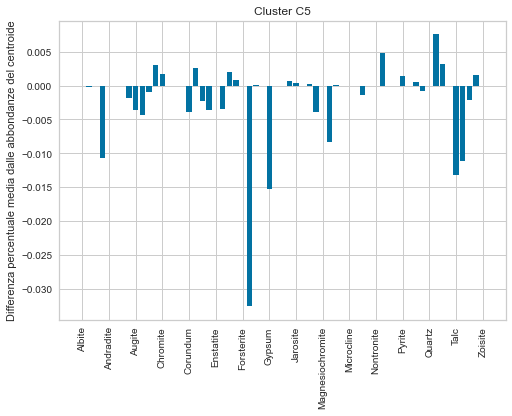

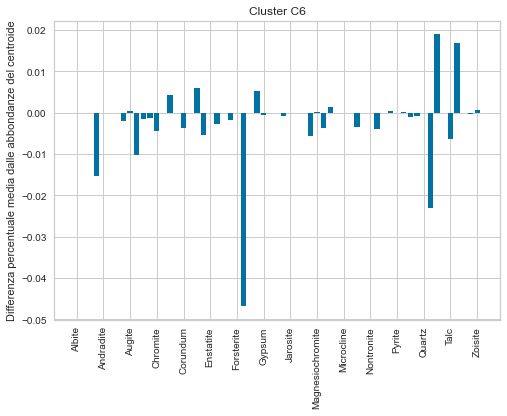

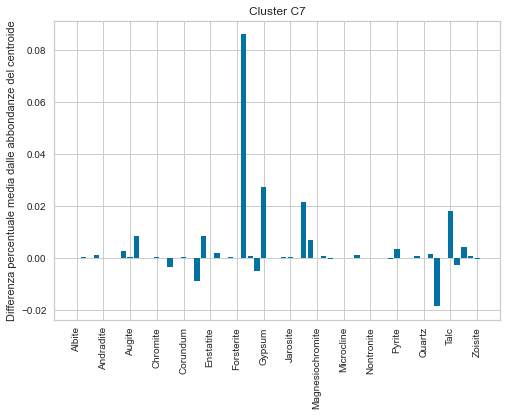

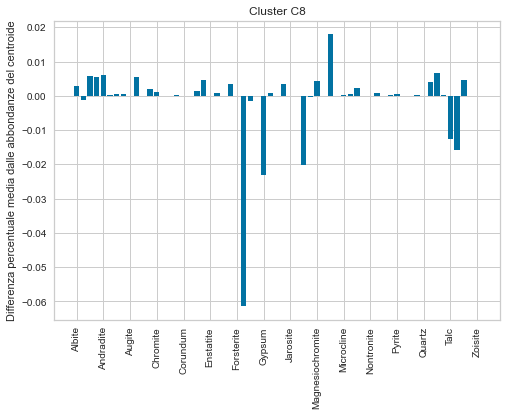

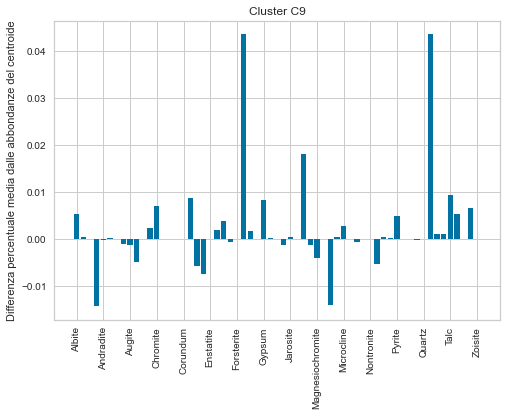

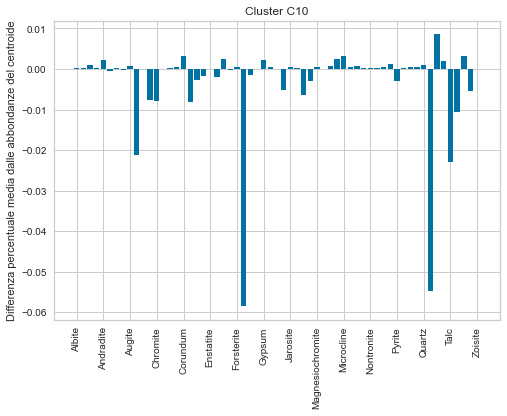

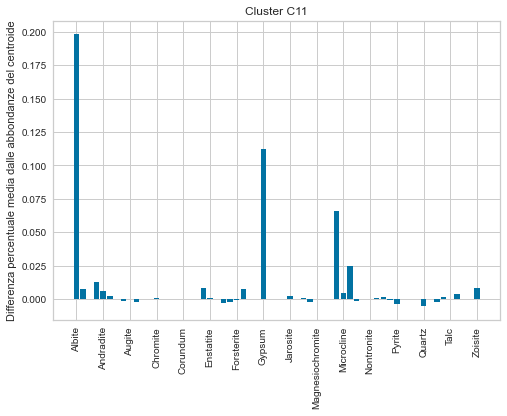

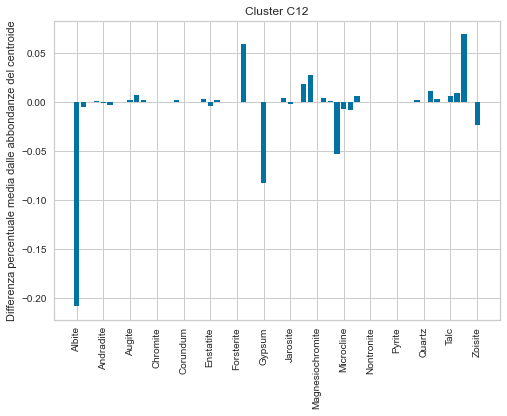

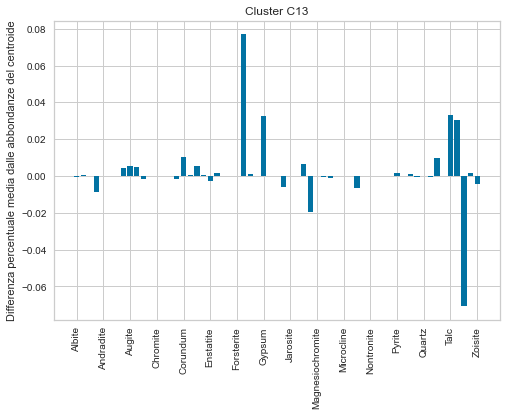

In [36]:
for i, r in enumerate(residuals_materiali):
    plt.xticks(np.arange(0, len(materials_label), 4), rotation='vertical')
    plt.bar(height = r, x = materials_label, align = "center")
    plt.ylabel("Differenza percentuale media dalle abbondanze del centroide")
    
    plt.title(f"Cluster C{i}")
    plt.show()
    plt.close('all')

In [41]:
residuals_materiali = np.array(residuals_materiali)
np.mean(residuals_materiali, axis = 0)

array([ 2.35425517e-03,  3.70774635e-04,  3.61701491e-04, -2.51127248e-03,
        9.43548044e-04,  1.88356916e-05, -5.89863749e-05,  2.48784897e-04,
        2.84293452e-04, -1.22331239e-03, -2.75401243e-04, -2.03849249e-04,
       -3.94454219e-05,  0.00000000e+00, -5.58124404e-05,  1.45425151e-04,
        4.28505153e-03,  1.17854558e-04, -4.07585810e-04,  3.23357595e-04,
       -2.81903530e-04,  8.93404720e-04,  6.59926478e-04,  1.44189507e-04,
        3.17151981e-05,  1.48489340e-03,  1.10445302e-05,  1.65507806e-05,
        4.71651858e-03,  1.68219570e-04,  1.46199899e-04, -5.69018412e-04,
        2.31730550e-04, -1.21731590e-05,  1.21286823e-04, -7.65930385e-04,
        1.12981517e-04,  3.76415173e-04,  2.40573369e-04,  3.03427374e-03,
        7.68804327e-04,  1.41365520e-03,  1.00165439e-05,  9.72620529e-06,
        2.05023940e-05,  1.39090680e-05,  4.65591046e-04, -6.45442600e-04,
        5.88627974e-05,  1.30546121e-04,  4.14024416e-04,  9.86613507e-05,
       -9.81954202e-04, -

sembra che ci siano in alcuni cluster differenze fino al 20%. Comunque, dobbiamo considerare che il centroide è stato minimizzato con un'altra metrica.
Questo ci da la possibilità, qualora i risultati di clusterizzazione non fossero soddisfacenti sperimentalmente, di analizzare gli spettrogrammi e clusterizzare rispetto alle abbondanze.

## Metodi alternativi...

Con più dati, si poteva usare un approccio più "black-box"... per cui potevamo trainare un'autoencoder a conv1d sugli spettrogrammi per poi clusterizzare la rappresentazione latente.

Un'altro approccio interessante - sempre in presenza di più dati - si basa sull'uso delle convoluzioni o ViT per lavorare sull'input considerato come immagine di input per ogni acquisizione $\textbf{X} \in \Bbb R^{11x11x2400} $ per poter far sempre un autoencoder e generare rappresentazioni latenti in grado di descrivere l'intera griglia 11x11.